In [2]:
import torch
from pathlib import Path

def load_model(path, map_location=None):
    path = Path(path)

    scaler_path = path.with_name("scaler.pt")
    scaler = torch.load(scaler_path)

    with open(path, "rb") as fin:
        model = torch.load(fin, map_location=map_location)

    ckpt_path = path.with_name(path.name + ".ckpt")
    if ckpt_path.exists():
        model.model = model.model.__class__.load_from_checkpoint(ckpt_path)
        model.trainer = None

    # print(model.trainer_params)
    model.trainer_params = {"enable_progress_bar": False, "logger": False}
    # model.trainer_params = {}

    if map_location == torch.device("cuda"):
        model.trainer_params["accelerator"] = "cuda"
        model.trainer_params["devices"] = [0]

    return model, scaler

map_location = torch.device("cpu")
# map_location = torch.device("cuda")
# map_location = None

path = "/home/beomyeol/Workspace/ibm/faro/results/pred/top9_twitter_1_2400_avgproc_min_int5m_reduced_6hr/darts/clen=15_plen=5/nhits/bs=32_lr=0.0001/b=1_s=3_l=2_lw=512_do=0.1_gaussian/model.pt"
model, scaler = load_model(path, map_location=map_location)

/home/beomyeol/anaconda3/envs/k8s-ray/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
context_len = model.input_chunk_length
pred_len = model.output_chunk_length
print(context_len)
print(pred_len)

15
5


In [4]:
import sys
sys.path.append("..")
import pandas as pd
from pred.utils import build_dataset_from_df
from darts import TimeSeries

# df = pd.read_pickle("../experiments/sample_twitter_1_2400_avgproc_min_int5m/sample_twitter_1_2400_avgproc_min.pkl")
# df = pd.read_pickle("../experiments/top9_twitter_1_2400_avgproc_min_int5m_reduced_6hr/top9_twitter_1_2400_avgproc_min_int5m_reduced_6hr.pkl")
df = pd.read_pickle("../experiments/top9_twitter_1_2000_avgproc_min_int5m_reduced_6hr_augmented/top9_twitter_1_2000_avgproc_min_int5m_reduced_6hr_augmented.pkl")
val = build_dataset_from_df(df[(df.day == 11) * (df["sample"] == 1)])
val = TimeSeries.from_group_dataframe(
        val, group_cols="group", time_col="time_idx", value_cols="value")

1


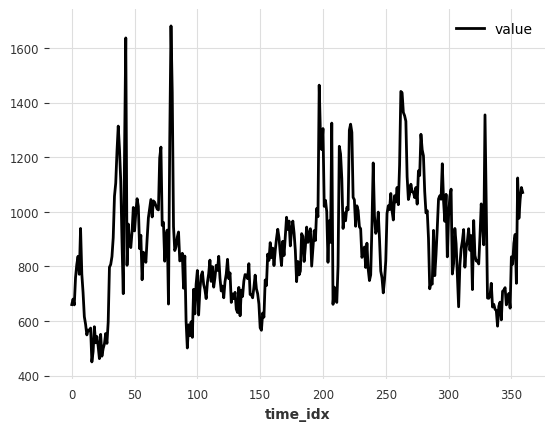

In [5]:
target_idx = 1
target = val[target_idx]
target = target
target.plot()

if len(scaler._fitted_params) == 1:
    scaler_idx = 0
else:
    scaler_idx = target_idx
print(scaler_idx)

In [10]:
import time
import numpy as np

base = 10
num_samples = 100
pred_len = max(5, pred_len)
series = target[base:base+context_len]
if scaler is None:
    scaled_series = series
else:
    scaled_series = scaler.ts_transform(series, scaler._fitted_params[scaler_idx])

tss = []
for _ in range(20):
    t = time.perf_counter()
    pred = model.predict(n=pred_len, series=scaled_series, num_loader_workers=4, num_samples=num_samples)
    tss.append(time.perf_counter() - t)
print(np.mean(tss))

# if scaler is None:
#     pred_out = pred
# else:
#     pred_out = scaler.ts_inverse_transform(pred, scaler._fitted_params[scaler_idx])
# target[base:base+context_len+pred_len].plot(label="origin")
# pred_out.plot(label="pred_correct")
# print(pred_out.values().reshape(-1))
# pred_out.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentile")
# pred_out.plot(low_quantile=0.8, high_quantile=0.8, label="80th percentile")
# pred_out.plot(low_quantile=0.9, high_quantile=0.9, label="90th percentile")

# scaled_series = scaler.transform(series)
# pred = model.predict(n=pred_len, series=scaled_series, num_samples=30)
# pred_out = scaler.inverse_transform(pred)
# pred_out.plot(label="pred_wrong")

0.1515217166626826


2023-03-25 12:01:30 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:30 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:31 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:31 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:31 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:31 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:31 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:32 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:32 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-25 12:01:32 pytorch_lightning.accelerators.cuda INFO: LO

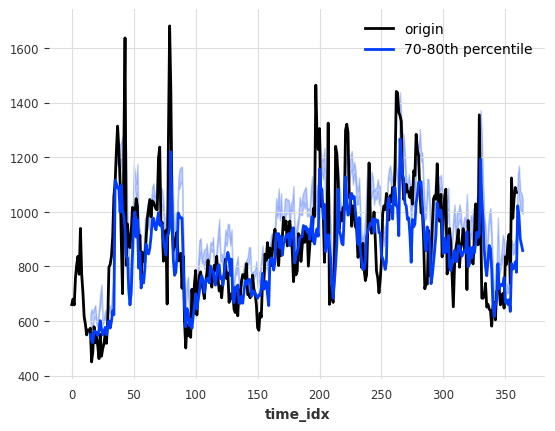

In [84]:
period = 5
pred_outs = None
num_samples = 100
for base in range(0, len(target), period):
# for base in range(0, 30, period):
    current = base + context_len
    series = target[base:base+context_len]
    if len(series) < context_len:
        continue
    if scaler is None:
        scaled_series = series
    else:
        scaled_series = scaler.ts_transform(series, scaler._fitted_params[scaler_idx])
    pred = model.predict(n=pred_len, series=scaled_series, num_loader_workers=4, num_samples=num_samples)
    if scaler is None:
        pred_out = pred
    else:
        pred_out = scaler.ts_inverse_transform(pred, scaler._fitted_params[scaler_idx])
    if pred_outs is None:
        pred_outs = pred_out[:period]
    else:
        pred_outs = pred_outs.concatenate(pred_out[:period])
    # pred_out.plot(label="value")

target.plot(label="origin")
# pred_outs.plot(label="pred")
# pred_outs.plot(low_quantile=0.8, high_quantile=0.8, label="80th percentile")
# pred_outs.plot(low_quantile=0.7, high_quantile=0.7, label="70th percentile")
pred_outs.plot(low_quantile=0.7, high_quantile=0.8, label="70-80th percentile")

AssertionError: 

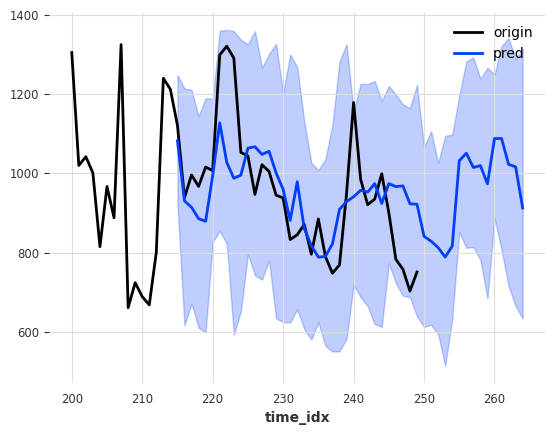

In [85]:
target[200:250].plot(label="origin")
pred_outs[200:250].plot(label="pred")
assert False

In [ ]:
import numpy as np

err = target[context_len:]-pred_outs[:-pred_len]
err.plot(label="error (origin-pred)")
print(np.mean(err.values()))

# idx = 0
idx = np.argmax(err.values())
print(idx)
print(err[idx].values())
print(target[10+idx].values())
print(pred_outs[idx].values())

2023-03-17 13:54:29 darts.timeseries ERROR: ValueError: Attempted to perform operation on two TimeSeries of unequal shapes.


ValueError: Attempted to perform operation on two TimeSeries of unequal shapes.

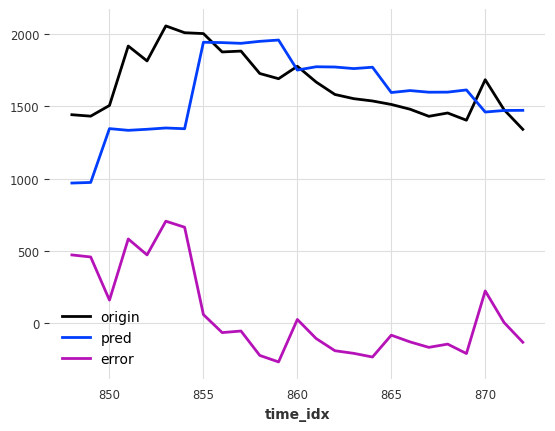

In [ ]:
# idx=833
begin = idx-context_len
end = begin+5*pred_len
target[context_len+begin:context_len+end].plot(label="origin")
pred_outs[begin:end].plot(label="pred")
err[begin:end].plot(label="error")

In [ ]:
import numpy as np

series = TimeSeries.from_values(np.random.normal(15, 5, context_len).round().astype(np.float32))
series.plot(label="origin")
if scaler is None:
    scaled_series = series
else:
    scaled_series = scaler.transform(series)
pred = model.predict(n=pred_len, series=scaled_series, num_loader_workers=1)
if scaler is None:
    pred_out = pred
else:
    pred_out = scaler.inverse_transform(pred)
pred_out.plot(label="pred")